# Decision Tree Baseline

This notebook will build a basic logistic regression model and evaluate results using cross-validation.

1. Read in the data
2. Create hold-out test set
3. Create pipeline for Decision Tree. 
    - Random Oversample of data to balance out target.
    - cross-validation of results; evaluation metrics are accuracy, f1 score, and AUC.
4. Interpret Decision Tree
    - Visualize the tree and determine possible decision rules.
    
    
#### Start with Dependencies
  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from data_import import preprocess_data
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline, Pipeline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from Evaluation import *

/home/jupyter-khickey550/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Load in the data

In [2]:
#load in the preprocessed data
data = preprocess_data('Statcast_data.csv')
target = data['description']
#filter out 'player_name'; will not use as a feature
#and filter out the target
data = data.iloc[:, :-2]

/home/jupyter-khickey550/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Create a training and a hold out set. 

In [3]:
#first, create a hold-out set as a final evaluation set
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 777, test_size = .2)

#then instatiate the model we will use: Decision Tree
tree = DecisionTreeClassifier(max_depth=4, random_state=777)

## Build a pipeline

#### Random Oversampler and the basic decision tree with max_depth = 4 so we can visualize the tree.

In [5]:
clf_pipe = Pipeline(steps= [
    ('sampler', RandomOverSampler(ratio = 1, random_state = 777)),
    ('clf', tree),
                            ])

## Cross Validate the scores

In [6]:
results = eval_model(clf_pipe, X_train, y_train, cv = 3)


Mean train_accuracy Value: 0.46323541650811956
train_accuracy scores: [0.4758223  0.46327897 0.45060497]

Mean test_accuracy Value: 0.4606384686588707
test_accuracy scores: [0.47051629 0.46584158 0.44555753]

Mean train_f1 Value: 0.47658632073904666
train_f1 scores: [0.47368421 0.47567706 0.48039769]

Mean test_f1 Value: 0.4745474069155133
test_f1 scores: [0.46781983 0.47825469 0.47756771]

Mean train_roc_auc Value: 0.5503934213695244
train_roc_auc scores: [0.55172702 0.548311   0.55114224]

Mean test_roc_auc Value: 0.5468987792222858
test_roc_auc scores: [0.54338351 0.5525882  0.54472463]

dict_keys(['memory', 'steps', 'verbose', 'sampler', 'clf', 'sampler__random_state', 'sampler__ratio', 'sampler__return_indices', 'sampler__sampling_strategy', 'clf__class_weight', 'clf__criterion', 'clf__max_depth', 'clf__max_features', 'clf__max_leaf_nodes', 'clf__min_impurity_decrease', 'clf__min_impurity_split', 'clf__min_samples_leaf', 'clf__min_samples_split', 'clf__min_weight_fraction_leaf', '

In [7]:
results[0][1]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=777, splitter='best')

## Interpretation

#### Visualize the decision tree that we created

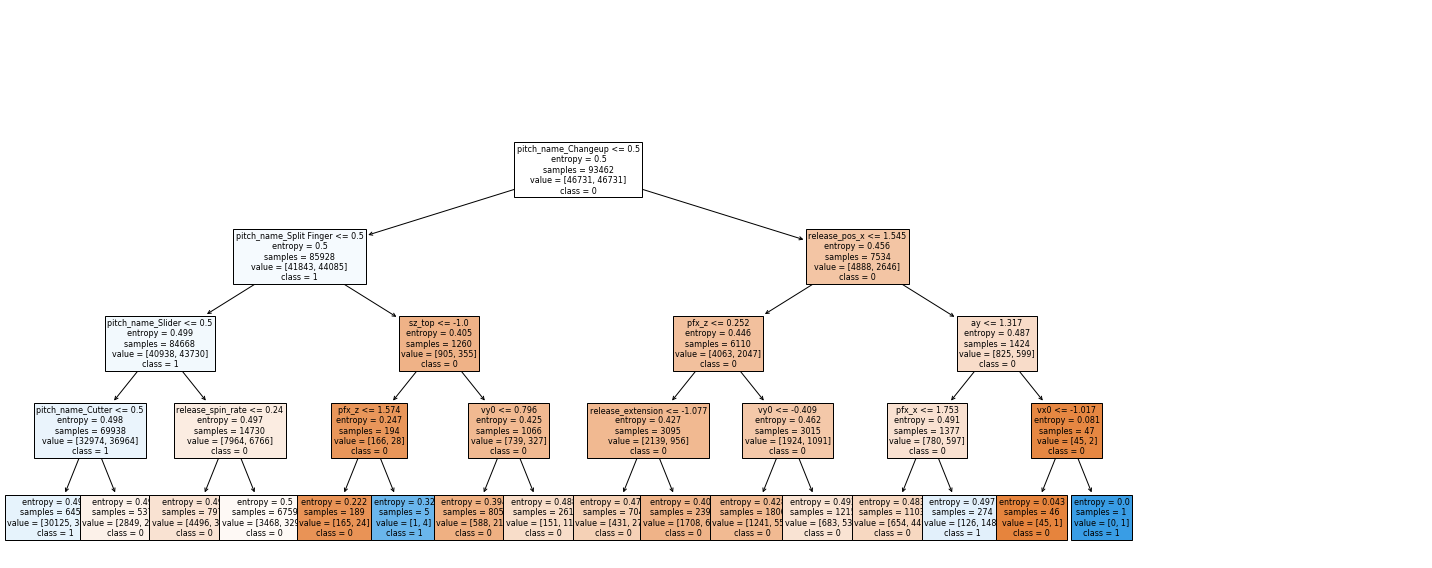

In [8]:
fig = plt.figure(figsize = (20, 8))
img = plot_tree(results[0][1], feature_names=X_train.columns, class_names = ['0', '1'], filled=True, fontsize = 8)
plt.tight_layout()
#fig.savefig('base_decision_tree.png')

# INTERPRETATION

A tree of this depth is not particularly useful; not only is the performance poor, but the types of decision rules it has determined are not very useful. Many of the splitting points at this depth are based on 'pitch_name', and many of the measurement features, such 'release_spin_rate', and 'pitch_speed', are used minimally or not used at all. One possible reason for the poor performance of a decision tree at this depth is it is too simple and is not capturing enough of the relationships between features, thus underfitting. Let's ensure that this model's performance is consistent using cross-validation 



## Results

Results indicate the the model has virtually no predictive power. It is likely somewhat underfitting the data. We'll try tuning hyperparameters now. The first and most prominent hyperparamter to tune is 'max_depth'. We will build a pipeline that will use GridSearch along with oversampling strategy to get scores based on a range of max_depth values and then visualize the performance of the values. 


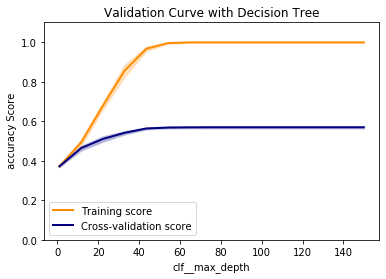

In [10]:
plot_validation_curve(clf_pipe, X_train, y_train, param_range = np.linspace(1,150,15), 
                      param_name = 'clf__max_depth', metric = 'accuracy')

## Hyperparameter tune

In [20]:
params_dict = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [int(x) for x in np.linspace(1, 100, 10)],
    'clf__min_samples_split': np.linspace(.1, 1.0, 10),
    'clf__max_features': np.linspace(.1, .9, 9)
        }

pipe_random_search, cv_results = hyperparam_search_pipeline(clf_pipe, X_train, y_train, 
                                                   parameter_dict=params_dict,n_iter = 100, 
                                                   cv = 3, refit = 'Accuracy')


Best performing model is: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=34,
                       max_features=0.1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.4,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=777, splitter='best')


## Make Predicitons on Test Set and Evaluate Results

In [21]:
def eval_test_set(pipeline, x_test):
    predictions = pipe_random_search.predict(X_test)
    print(accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))
eval_test_set(pipe_random_search, X_test)

0.4741419475073769
              precision    recall  f1-score   support

           0       0.68      0.43      0.53     17500
           1       0.32      0.57      0.41      8256

    accuracy                           0.47     25756
   macro avg       0.50      0.50      0.47     25756
weighted avg       0.56      0.47      0.49     25756



In [17]:
predictions = pipe_random_search.predict(X_test)

In [18]:
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.4741419475073769
              precision    recall  f1-score   support

           0       0.68      0.43      0.53     17500
           1       0.32      0.57      0.41      8256

    accuracy                           0.47     25756
   macro avg       0.50      0.50      0.47     25756
weighted avg       0.56      0.47      0.49     25756



In [ ]:
#pipe_random_search[1]
#fig = plt.figure(figsize = (20, 8))
#img = plot_tree(pipe_random_search[1], feature_names=X_train.columns, class_names = ['0', '1'], filled=True, fontsize = 8)
#plt.tight_layout()

('clf__max_depth', array([  1.,  26.,  51.,  76., 101.]))


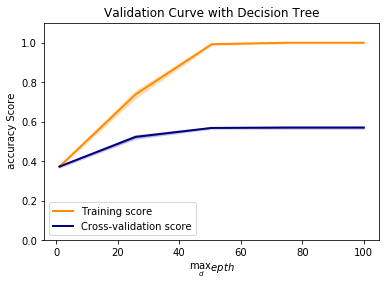

('clf__min_impurity_split', array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]))


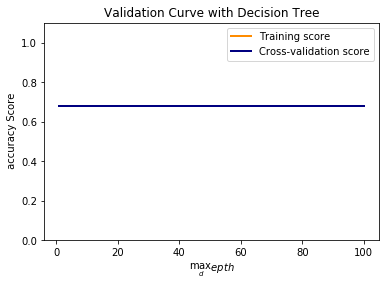

In [35]:
params_to_check = ['clf__max_depth', 'clf__min_impurity_split']
params_values = [np.linspace(1, 101,5), np.linspace(.01, .2, 10)]

for param in zip(params_to_check, params_values):
    print(param)
    plot_validation_curve(clf_pipe, X_train, y_train, param_range = param[1], param_name = param[0], metric = 'accuracy')